In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
EPOCHS = 30
data_dir = "/content/drive/MyDrive/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [ ]:
# Define a function for data transformations
def data_transforms(phase):
    # If the phase is TRAIN
    if phase == TRAIN:
        # Compose transformations: Resize, CenterCrop, Convert to Tensor, Normalize
        transform = transforms.Compose([
            transforms.Resize(256),  # Resize the image to 256x256 pixels
            transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])

    # If the phase is VAL
    if phase == VAL:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == TEST:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


In [ ]:
# Create a dictionary of datasets for each phase (TRAIN, VAL, TEST)
# For each phase, load the images from the corresponding folder and apply the data transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

# Create a dictionary of dataloaders for each phase
# For each phase, create a DataLoader that loads the data from the corresponding dataset
# The batch size and shuffle parameters can be adjusted as needed
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}

In [ ]:
len(dataloaders[TRAIN])

1304

In [ ]:
# sizes of the datasets
dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

#classes from the training dataset
classes = image_datasets[TRAIN].classes

#class names from the training dataset
class_names = image_datasets[TRAIN].classes

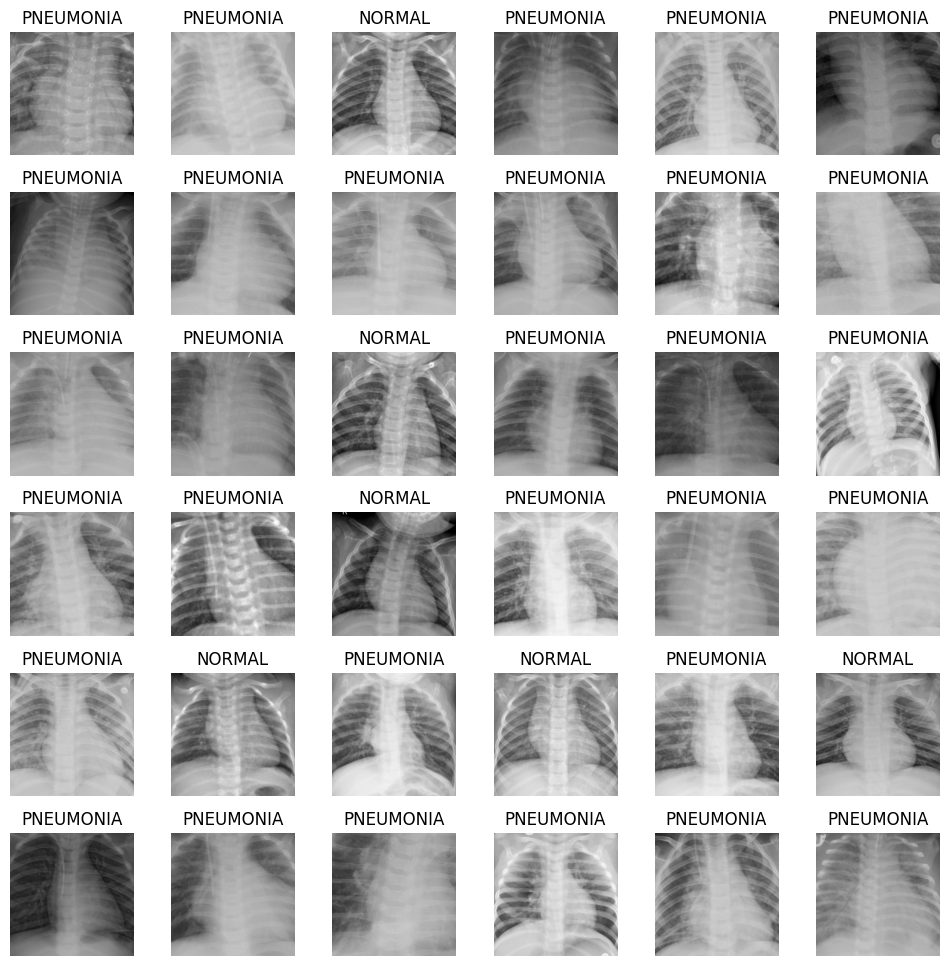

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [ ]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    #initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        # Each epoch has a training and validation phase
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_pre = models.resnet101()

In [ ]:
for param in model_pre.parameters():
    param.requires_grad = False

model_pre.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
print(model_pre)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.4036 Acc: 0.7987
val Loss: 0.8626 Acc: 0.6250
Epoch: 2/30
train Loss: 0.3908 Acc: 0.8023
val Loss: 0.7822 Acc: 0.6250
Epoch: 3/30
train Loss: 0.3818 Acc: 0.8115
val Loss: 0.9112 Acc: 0.6250
Epoch: 4/30
train Loss: 0.3935 Acc: 0.7970
val Loss: 0.7037 Acc: 0.7500
Epoch: 5/30
train Loss: 0.3823 Acc: 0.8117
val Loss: 0.5336 Acc: 0.6250
Epoch: 6/30
train Loss: 0.3805 Acc: 0.8079
val Loss: 0.5911 Acc: 0.6875
Epoch: 7/30
train Loss: 0.3997 Acc: 0.7862
val Loss: 0.5533 Acc: 0.7500
Epoch: 8/30
train Loss: 0.3880 Acc: 0.8027
val Loss: 0.6840 Acc: 0.6875
Epoch: 9/30
train Loss: 0.3865 Acc: 0.8069
val Loss: 0.7452 Acc: 0.6250
Epoch: 10/30
train Loss: 0.3776 Acc: 0.8156
val Loss: 0.8116 Acc: 0.6250
Epoch: 11/30
train Loss: 0.3731 Acc: 0.8223
val Loss: 0.6323 Acc: 0.6875
Epoch: 12/30
train Loss: 0.3650 Acc: 0.8248
val Loss: 0.8323 Acc: 0.6250
Epoch: 13/30
train Loss: 0.3640 Acc: 0.8244
val Loss: 0.8194 Acc: 0.6250
Epoch: 14/30
train Loss: 0.3696 Acc: 0.8219
val Loss: 0.5954 Acc: 0.6875

In [ ]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

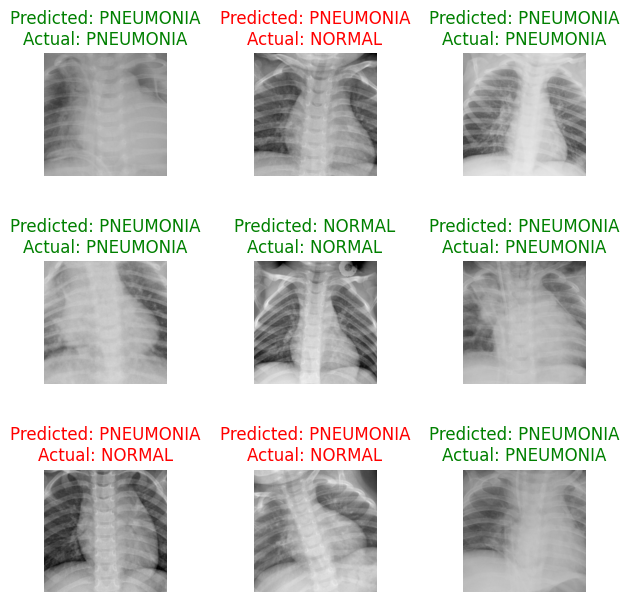

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 485.0 
Total Test Images: 624.0
Test Accuracy:  0.7772435897435898
